In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import requests
from io import BytesIO
from keras.preprocessing import image
from google.colab import drive

In [ ]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Define Data Paths
data_dir = '/content/drive/MyDrive/dataset/resized_raw_images'
train_data_path = '/content/drive/MyDrive/dataset/resized_raw_images/training_data'
validation_data_path = '/content/drive/MyDrive/dataset/resized_raw_images/validation_data'


In [ ]:
# function to check images during augmentation
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 3: Data Augmentation and Preprocessing (we will reduce image size to 150,150)
img_size = (150, 150)
batch_size = 32

In [ ]:
# Augmentation
training_datagen =  ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  # Adjust brightness
    channel_shift_range=50.0,       # Increase or decrease RGB channels
    fill_mode='nearest')



In [ ]:
# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_data_path, # this is the target directory
                                      target_size=(150, 150), # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='sparse')

Found 1101 images belonging to 14 classes.


In [ ]:
# determine total number of classes
training_data.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bakanae': 2,
 'brown_spot': 3,
 'grassy_stunt_virus': 4,
 'healthy_rice_plant': 5,
 'narrow_brown_spot': 6,
 'ragged_stunt_virus': 7,
 'rice_blast': 8,
 'rice_false_smut': 9,
 'sheath_blight': 10,
 'sheath_rot': 11,
 'stem_rot': 12,
 'tungro_virus': 13}

In [ ]:
# rescaling validation images ie normalization
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='sparse'  # Assuming it's a sparse categorical problem
# )


In [ ]:
# this is a similar generator, for validation data
valid_data = valid_datagen.flow_from_directory(validation_data_path,
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='sparse')

Found 279 images belonging to 14 classes.


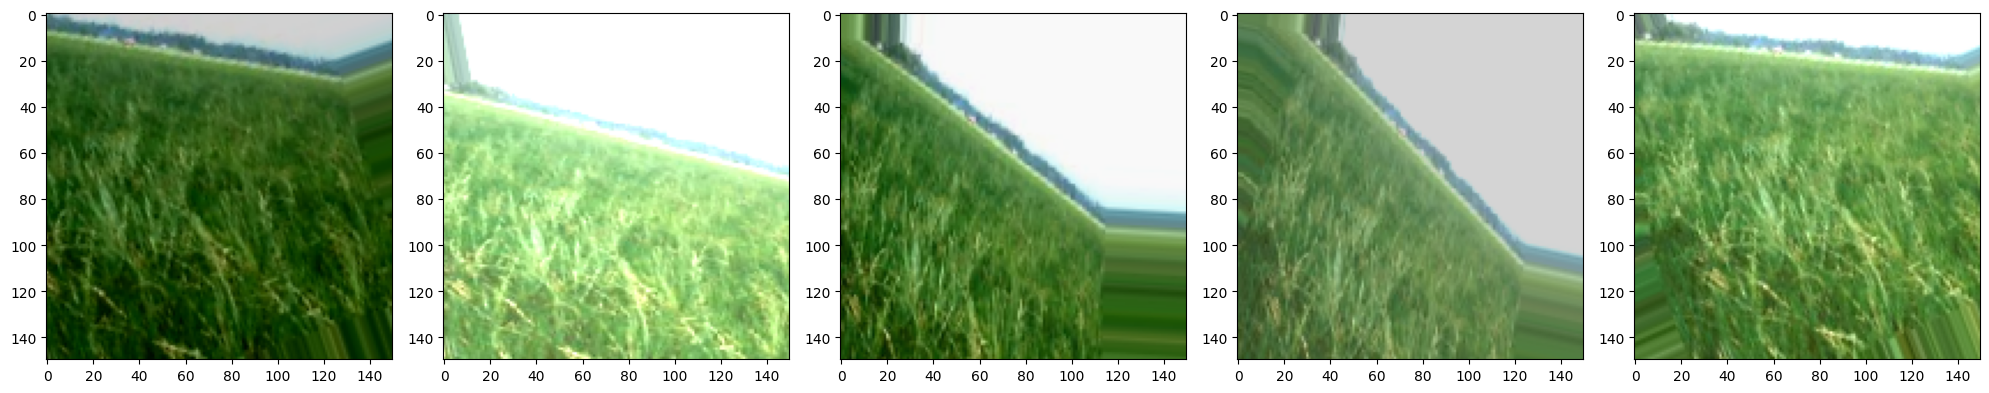

In [ ]:
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)


In [ ]:
model_path = '/content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Step 4: Build CNN Model
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=3),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=3),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=3),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.1),
    Dense(units=256, activation='relu'),
    Dropout(0.25),
    Dense(units=14, activation='softmax')  # Adjusted to 14 classes
])

# cnn_model = Sequential()
# cnn_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(64, activation='relu'))
# cnn_model.add(Dense(14, activation='softmax'))

In [ ]:
# Compile the model with Adam optimizer, specified learning rate, and sparse categorical crossentropy loss
cnn_model.compile(optimizer=Adam(lr=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
# # Step 5: Callbacks (Early Stopping and Model Checkpoint)
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model.h5',
#                                    monitor='val_accuracy',
#                                    verbose=1,
#                                    save_best_only=True,
#                                    mode='max')  # Save the best model based on validation accuracy

# callbacks_list = [early_stopping, model_checkpoint]

In [ ]:
# train cnn model
history = cnn_model.fit(training_data,
                          epochs=500,
                          verbose=1,
                          validation_data= valid_data,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/500
35/35 [==============================] - ETA: 0s - loss: 2.4495 - accuracy: 0.1862 
Epoch 1: val_accuracy improved from -inf to 0.30824, saving model to /content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5
35/35 [==============================] - 495s 14s/step - loss: 2.4495 - accuracy: 0.1862 - val_loss: 2.2028 - val_accuracy: 0.3082
Epoch 2/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - ETA: 0s - loss: 2.0680 - accuracy: 0.3197
Epoch 2: val_accuracy improved from 0.30824 to 0.46237, saving model to /content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5
35/35 [==============================] - 14s 398ms/step - loss: 2.0680 - accuracy: 0.3197 - val_loss: 1.7301 - val_accuracy: 0.4624
Epoch 3/500
35/35 [==============================] - ETA: 0s - loss: 1.9749 - accuracy: 0.3506
Epoch 3: val_accuracy did not improve from 0.46237
35/35 [==============================] - 13s 368ms/step - loss: 1.9749 - accuracy: 0.3506 - val_loss: 1.9434 - val_accuracy: 0.3405
Epoch 4/500
35/35 [==============================] - ETA: 0s - loss: 1.9530 - accuracy: 0.3678
Epoch 4: val_accuracy improved from 0.46237 to 0.48029, saving model to /content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5
35/35 [==============================] - 14s 394ms/step - loss: 1.9530 - accuracy: 0.3678 - val_loss: 1.4944 - val_accuracy: 0.4803
Epoch 5/500
35

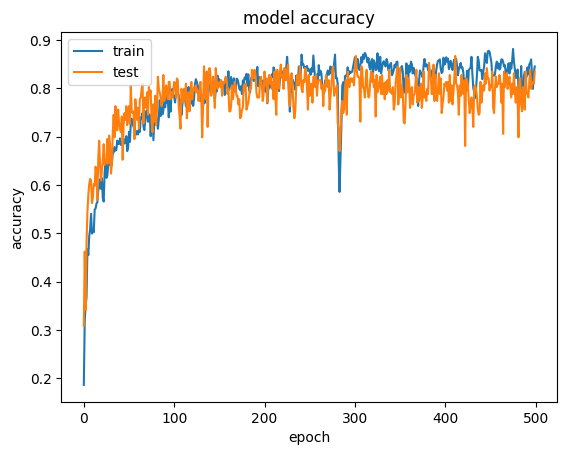

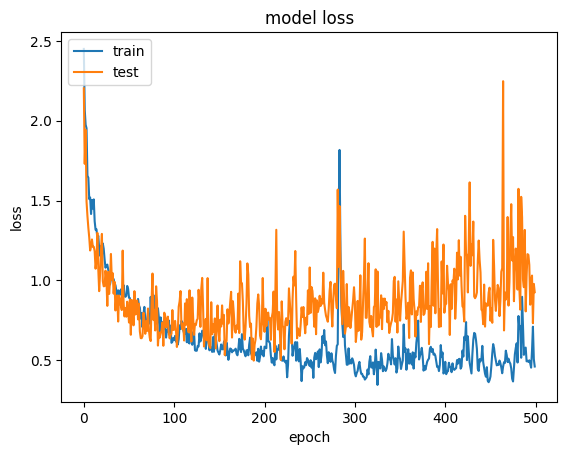

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9/9 [==============================] - 1s 109ms/step


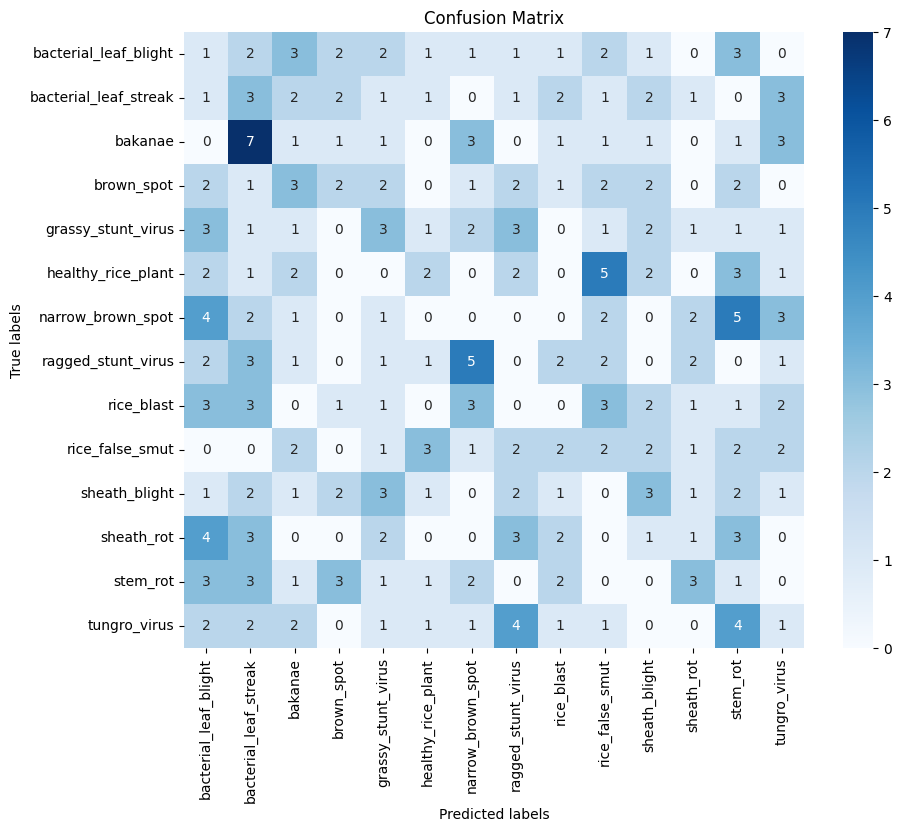

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# After training the model

# Use the trained model to make predictions on the validation data
y_pred = cnn_model.predict(valid_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels
true_classes = valid_data.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_data.class_indices.keys(),
            yticklabels=valid_data.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
history.history

{'loss': [2.4495279788970947,
  2.068002939224243,
  1.9749208688735962,
  1.9530072212219238,
  1.6558475494384766,
  1.6436408758163452,
  1.5093472003936768,
  1.5195261240005493,
  1.4160488843917847,
  1.5038524866104126,
  1.449841022491455,
  1.5074867010116577,
  1.3706417083740234,
  1.3172804117202759,
  1.3203352689743042,
  1.2650645971298218,
  1.2800798416137695,
  1.2004196643829346,
  1.1547884941101074,
  1.2166049480438232,
  1.1553049087524414,
  1.2317564487457275,
  1.1985987424850464,
  1.1312264204025269,
  1.0795600414276123,
  1.094881534576416,
  1.0992767810821533,
  1.067456603050232,
  1.0432510375976562,
  0.9747202396392822,
  1.009453535079956,
  1.0425723791122437,
  1.0043174028396606,
  1.0084930658340454,
  0.9775834083557129,
  0.971061110496521,
  0.9347317218780518,
  0.844428300857544,
  0.9382869601249695,
  0.9276936054229736,
  0.9130480885505676,
  0.9436340928077698,
  0.9042171239852905,
  0.9165279269218445,
  0.970780074596405,
  0.902198

In [ ]:
# Step 7: Save the Final Model

model_path = '/content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5'
cnn_model.save(model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = '/content/drive/MyDrive/dataset/rpdp.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#step 9 convert modedl to tflite

In [ ]:
# Print the first few labels from training_data
for i in range(5):  # Print the first 5 labels
    print(training_data[i][1])


[ 3.  1. 12.  9. 12.  3. 12. 11.  3. 13. 12.  3. 12.  2.  8.  9. 10.  7.
 12.  3. 13.  8.  5.  7. 11.  9.  0.  6.  2. 13. 11.  7.]
[11. 13. 10. 10.  9. 11.  9.  3.  6.  9. 12.  4. 13.  5. 11. 12.  9.  2.
  2.  5.  3.  6.  3.  9. 13. 12.  0. 13.  7. 13.  8.  2.]
[ 1. 12.  6.  9.  5.  8.  8.  8.  1. 13. 12. 12. 10.  1. 12.  1.  2.  1.
  4.  3.  0. 10.  9.  8. 11.  5.  8.  1.  4.  4.  4.  4.]
[ 9.  2. 11.  2.  3. 11. 12.  1.  4.  8.  4.  0.  6.  6.  6.  4. 11.  9.
 10. 11. 12. 13.  2.  5. 13.  7.  5.  8.  9.  6.  3.  4.]
[ 3.  7.  0. 12.  6.  0. 13.  4. 13.  4.  5.  6.  9.  6. 10.  8.  4. 12.
 13.  2. 13.  6.  0.  9. 11.  4.  1.  7.  8.  9.  4.  3.]


In [ ]:
# Make predictions on validation data
predictions = cnn_model.predict(valid_data)

# predictions will contain the predicted probabilities for each class for each sample
# You can use argmax to get the class with the highest probability as the predicted class
predicted_classes = np.argmax(predictions, axis=1)

# Print some of the predicted classes
print(predicted_classes)


9/9 [==============================] - 1s 116ms/step
[ 4 13 10  3  6  1  9 10  5 10  1 12 10  1  9  6 10  9 10  0  2  4  3  2
  2  9  1 13  7 12 11  2  9  7  7  4  2  4 12 12 13  9  1  4 10  0  0  2
  1  1  6 12  5  3 10 13  5 10  4  2  5  9  3  1  9  1 10 12  7  1 13  2
  4  0  9  8 12  9  5  5  5  1  7 11  0  0 11  0 10  3  8  9  0 13  9  1
 11  1  0  2 13 11  5  7 12  9  3  1  5  2  7  2  0  7  7  5  7 13  5 13
 13  1  7 10  8  3  1 13  3  3  9  2  8 13  1  4 10  6  6  2  0 11  8  6
 11  6  3  5  7  1 13 12 12  5 10  6 12  0  1  6  6 13  2  5 11  6  8 12
  4 12  5  7  0 11 13  4 12  1  1  9 11  7  2  5  6  1  1  5  2  0  9 10
  7  0  0  1  4  7 10  1  3 12  9  3  2 10  4  6  8  8  1  5  1  0  2  9
 11  8  4  1  4 12  4 12  1  7  7  6  9 12 12 12  2 11 12  4  1  2 10  6
  1  9  6  8  7  1 13  0 10  7  9  3  6  4  2 12  4  1  6  5  8  9  9 10
  1  8 10 11 10 11  8  8  5  1  8 10  4 13  4]


1/1 [==============================] - 0s 77ms/step


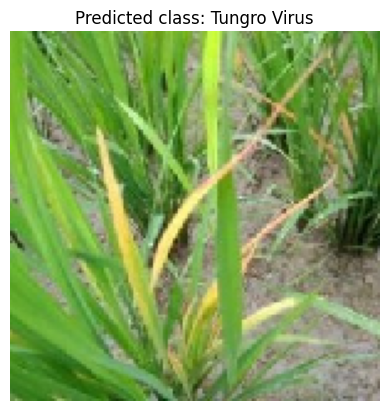

Prediction Probabilities:
Bacterial Leaf Blight: 0.0001
Bacterial Leaf Streak: 0.0000
Bakanae: 0.0015
Brown Spot: 0.0000
Grassy Stunt Virus: 0.0000
Healthy Rice Plant: 0.0000
Narrow Brown Spot: 0.0000
Ragged Stunt Virus: 0.0001
Rice Blast: 0.0078
Rice False Smut: 0.0061
Sheath Blight: 0.0000
Sheath Rot: 0.0000
Stem Rot: 0.0001
Tungro Virus: 0.9844


In [ ]:
# Load the image
img_path = '/content/drive/MyDrive/dataset/resized_raw_images/validation_data/tungro_virus/Tungro_virus (62).jpg'
img = image.load_img(img_path, target_size=(150, 150))  # Resize the image to 150x150

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 150, 150, 3) for a single image

# Preprocess the image (e.g., rescaling)
img_array = img_array / 255.0  # Rescale pixel values to [0, 1]

# Make predictions
predictions = cnn_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Map the predicted class index to the actual class name
predicted_class = class_names[predicted_class_index]

# Visualize the image
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Print the prediction probabilities for each class
print("Prediction Probabilities:")
for class_name, prob in zip(class_names, predictions[0]):
    print(f"{class_name}: {prob:.4f}")


In [ ]:
# Assuming you have training_data.class_indices which is a dictionary mapping class names to their indices

# Define the list of class names based on the class indices
class_indices = training_data.class_indices
class_names = list(class_indices.keys())

# URL of the image
url = 'https://soybeanresearchinfo.com/wp-content/uploads/2020/04/SoyFG_Fig076-Bacterial-blight-coalescing-lesion-Daren-Mueller-scaled_1280x720_acf_cropped.jpg'

# Send a GET request to the URL to download the image
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image using PIL (Python Imaging Library)
    img = Image.open(BytesIO(response.content))

    # Resize the image to the desired input shape
    img = img.resize((150, 150))  # Resize the image to 150x150

    # Convert the image to a numpy array
    img_array = np.array(img)

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 150, 150, 3) for a single image

    # Preprocess the image (e.g., rescaling)
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]

    # Make predictions
    predictions = cnn_model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Map the predicted class index to the actual class name
    predicted_class = class_names[predicted_class_index]

    # Print the predicted class
    print("Predicted class:", predicted_class)

    # Dictionary mapping disease classes to categories
    class_to_category = {
        'Rice Blast': 'Fungal',
        'Sheath Blight': 'Fungal',
        'Brown Spot': 'Fungal',
        'Narrow Brown Spot': 'Fungal',
        'Sheath Rot': 'Fungal',
        'Stem Rot': 'Fungal',
        'Bakanae': 'Fungal',
        'Rice False Smut': 'Fungal',
        'Bacterial Leaf Blight': 'Bacterial',
        'Bacterial Leaf Streak': 'Bacterial',
        'Tungro Virus': 'Viral',
        'Ragged Stunt Virus': 'Viral',
        'Grassy Stunt Virus': 'Viral'
    }

    # Get the category based on the predicted disease class
    predicted_category = class_to_category.get(predicted_class, 'Unknown')

    # Print the predicted category
    print("Predicted category:", predicted_category)

    # Print the prediction probabilities for each class
    print("Prediction Probabilities:")
    for class_name, prob in zip(class_names, predictions[0]):
        print(f"{class_name}: {prob:.4f}")
else:
    print("Failed to download the image.")


1/1 [==============================] - 0s 85ms/step
Predicted class: bakanae
Predicted category: Unknown
Prediction Probabilities:
bacterial_leaf_blight: 0.0000
bacterial_leaf_streak: 0.0000
bakanae: 1.0000
brown_spot: 0.0000
grassy_stunt_virus: 0.0000
healthy_rice_plant: 0.0000
narrow_brown_spot: 0.0000
ragged_stunt_virus: 0.0000
rice_blast: 0.0000
rice_false_smut: 0.0000
sheath_blight: 0.0000
sheath_rot: 0.0000
stem_rot: 0.0000
tungro_virus: 0.0000


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model_path = '/content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5'
loaded_model = load_model(model_path)

# Function to preprocess an image
def preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    img_array = img_array / 255.0  # Rescale pixel values
    return img_array

# Function to predict the class of an image
def predict_image_class(image_path, model):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    return predicted_class_index

# Provided image path
image_path = '/content/drive/MyDrive/dataset/resized_raw_images/validation_data/tungro_virus/Tungro_virus (62).jpg'

# Predict the class for the image
predicted_class_index = predict_image_class(image_path, loaded_model)
print(f"Predicted Class Index: {predicted_class_index}")

1/1 [==============================] - 2s 2s/step
Predicted Class Index: 13


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model_path = '/content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5'
loaded_model = load_model(model_path)

# Function to preprocess an image
def preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    img_array = img_array / 255.0  # Rescale pixel values
    return img_array

# Function to predict the class of an image
def predict_image(image_path, model):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class index and probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_probability = predictions[0][predicted_class_index]

    # Load the class names
    class_names = [
        'bacterial_leaf_blight', 'bacterial_leaf_streak', 'bakanae', 'brown_spot',
        'grassy_stunt_virus', 'healthy_rice_plant', 'narrow_brown_spot',
        'ragged_stunt_virus', 'rice_blast', 'rice_false_smut',
        'sheath_blight', 'sheath_rot', 'stem_rot', 'tungro_virus'
    ]

    # Map the predicted class index to class name
    predicted_class_name = class_names[predicted_class_index]

    # Map the predicted class name to category
    class_to_category = {
        'bacterial_leaf_blight': 'Bacterial',
        'bacterial_leaf_streak': 'Bacterial',
        'bakanae': 'Unknown',
        'brown_spot': 'Fungal',
        'grassy_stunt_virus': 'Viral',
        'healthy_rice_plant': 'Unknown',
        'narrow_brown_spot': 'Fungal',
        'ragged_stunt_virus': 'Viral',
        'rice_blast': 'Fungal',
        'rice_false_smut': 'Fungal',
        'sheath_blight': 'Fungal',
        'sheath_rot': 'Fungal',
        'stem_rot': 'Fungal',
        'tungro_virus': 'Viral'
    }

    predicted_category = class_to_category.get(predicted_class_name, 'Unknown')

    # Print the prediction
    print(f"Predicted Class: {predicted_class_name}")
    print(f"Predicted Category: {predicted_category}")
    print("Prediction Probabilities:")
    for class_name, prob in zip(class_names, predictions[0]):
        print(f"{class_name}: {prob:.4f}")

# Provided image path
# image_path = '/content/drive/MyDrive/dataset/resized_raw_images/validation_data/tungro_virus/Tungro_virus (62).jpg'
image_path = '/content/drive/MyDrive/dataset/resized_raw_images/validation_data/stem_rot/Stem_rot (96).jpeg'

# Predict the class for the image
predict_image(image_path, loaded_model)


1/1 [==============================] - 0s 79ms/step
Predicted Class: stem_rot
Predicted Category: Fungal
Prediction Probabilities:
bacterial_leaf_blight: 0.0000
bacterial_leaf_streak: 0.0000
bakanae: 0.0000
brown_spot: 0.0000
grassy_stunt_virus: 0.0000
healthy_rice_plant: 0.0000
narrow_brown_spot: 0.0000
ragged_stunt_virus: 0.0000
rice_blast: 0.0000
rice_false_smut: 0.0033
sheath_blight: 0.0000
sheath_rot: 0.0013
stem_rot: 0.9953
tungro_virus: 0.0000


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# Load the saved model
model_path = '/content/drive/MyDrive/dataset/resized_raw_images/A+_rpdp.h5'
loaded_model = load_model(model_path)

# Function to preprocess an image
def preprocess_image(img, target_size=(150, 150)):
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    img_array = img_array / 255.0  # Rescale pixel values
    return img_array

# Function to predict the class of an image
def predict_image(image_url, model):
    # Send a GET request to the URL to download the image
    response = requests.get(image_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the image using PIL (Python Imaging Library)
        img = Image.open(BytesIO(response.content))

        # Preprocess the image
        img_array = preprocess_image(img)

        # Make predictions
        predictions = model.predict(img_array)

        # Get the predicted class index and probability
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_probability = predictions[0][predicted_class_index]

        # Load the class names
        class_names = [
            'bacterial_leaf_blight', 'bacterial_leaf_streak', 'bakanae', 'brown_spot',
            'grassy_stunt_virus', 'healthy_rice_plant', 'narrow_brown_spot',
            'ragged_stunt_virus', 'rice_blast', 'rice_false_smut',
            'sheath_blight', 'sheath_rot', 'stem_rot', 'tungro_virus'
        ]

        # Map the predicted class index to class name
        predicted_class_name = class_names[predicted_class_index]

        # Map the predicted class name to category
        class_to_category = {
            'bacterial_leaf_blight': 'Bacterial',
            'bacterial_leaf_streak': 'Bacterial',
            'bakanae': 'Fungal',  # Corrected category
            'brown_spot': 'Fungal',
            'grassy_stunt_virus': 'Viral',
            'healthy_rice_plant': 'Unknown',
            'narrow_brown_spot': 'Fungal',
            'ragged_stunt_virus': 'Viral',
            'rice_blast': 'Fungal',
            'rice_false_smut': 'Fungal',
            'sheath_blight': 'Fungal',
            'sheath_rot': 'Fungal',
            'stem_rot': 'Fungal',
            'tungro_virus': 'Viral'
        }

        predicted_category = class_to_category.get(predicted_class_name, 'Unknown')

        # Print the prediction
        print(f"Predicted Class: {predicted_class_name}")
        print(f"Predicted Category: {predicted_category}")
        print("Prediction Probabilities:")
        for class_name, prob in zip(class_names, predictions[0]):
            print(f"{class_name}: {prob:.4f}")
    else:
        print("Failed to download the image.")

# URL of the image from the internet
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRACULwDzmhcVKKdE0jA2Rq-IrQeBYp3rwNjw&usqp=CAU'  # Replace with the actual image URL

# Predict the class for the image
predict_image(image_url, loaded_model)


1/1 [==============================] - 0s 137ms/step
Predicted Class: bakanae
Predicted Category: Fungal
Prediction Probabilities:
bacterial_leaf_blight: 0.0000
bacterial_leaf_streak: 0.0000
bakanae: 1.0000
brown_spot: 0.0000
grassy_stunt_virus: 0.0000
healthy_rice_plant: 0.0000
narrow_brown_spot: 0.0000
ragged_stunt_virus: 0.0000
rice_blast: 0.0000
rice_false_smut: 0.0000
sheath_blight: 0.0000
sheath_rot: 0.0000
stem_rot: 0.0000
tungro_virus: 0.0000
